In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import string
from tqdm import tqdm
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ntsation/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('tweets_analyze/covid19_tweets.csv')
tqdm.pandas()

In [3]:
# Análise de sentimentos usando TextBlob
def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['sentiment'] = df['text'].progress_apply(get_sentiment)


100%|█████████████████████████████████████████████████████████████████████████| 179108/179108 [01:01<00:00, 2911.24it/s]


In [4]:
# Análise de tópicos usando Latent Dirichlet Allocation (LDA)
def get_lda_topics(texts, num_topics=5):
    stop_words = set(stopwords.words('english'))
    
    # Pré-processamento de texto
    tqdm.pandas(desc="Preprocessing Text")
    texts = texts.progress_apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]))
    
    # Vectorizer
    tqdm.pandas(desc="Vectorizing Text")
    vectorizer = CountVectorizer(max_df=0.85, max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(tqdm(texts, desc="Creating Document-Term Matrix", leave=False))
    
    # LDA Model
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    
    # Fitting LDA Model com barra de progresso manual
    n_iterations = int(len(texts) / 5000) + 1
     # Ajuste conforme necessário
    for _ in tqdm(range(n_iterations), desc="Fitting LDA Model"):
        lda.partial_fit(X)
    
    return lda, vectorizer
num_topics = 5
lda_model, vectorizer = get_lda_topics(df['text'], num_topics=num_topics)

Fitting LDA Model: 100%|████████████████████████████████████████████████████████████████| 36/36 [14:35<00:00, 24.33s/it]


In [5]:
# Visualização de tópicos
def plot_lda_topics(lda_model, vectorizer, num_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in tqdm(enumerate(lda_model.components_), desc='Topics'):
        print(f"\nTop Words for Topic #{topic_idx + 1}:")
        print([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])
plot_lda_topics(lda_model, vectorizer)

Topics: 5it [00:00, 1317.47it/s]


Top Words for Topic #1:
['covid19', 'mask', 'realdonaldtrump', 'help', 'masks', 'spread', 'new', 'read', 'going', 'coronavirus']

Top Words for Topic #2:
['covid19', 'pandemic', 'health', 'need', 'time', 'vaccine', 've', 'coronavirus', 'global', 'says']

Top Words for Topic #3:
['covid19', 'covid', '19', 'coronavirus', 'trump', 'world', 'people', 'testing', 'tested', 'positive']

Top Words for Topic #4:
['covid19', 'amp', 'people', 'like', 'know', 'virus', 'home', 'country', 'latest', 'good']

Top Words for Topic #5:
['covid19', 'cases', 'new', 'deaths', 'coronavirus', '2020', 'india', 'total', 'day', '000']


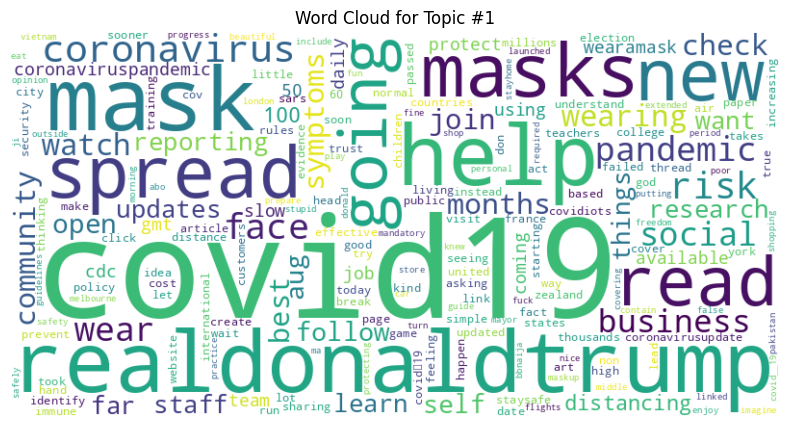

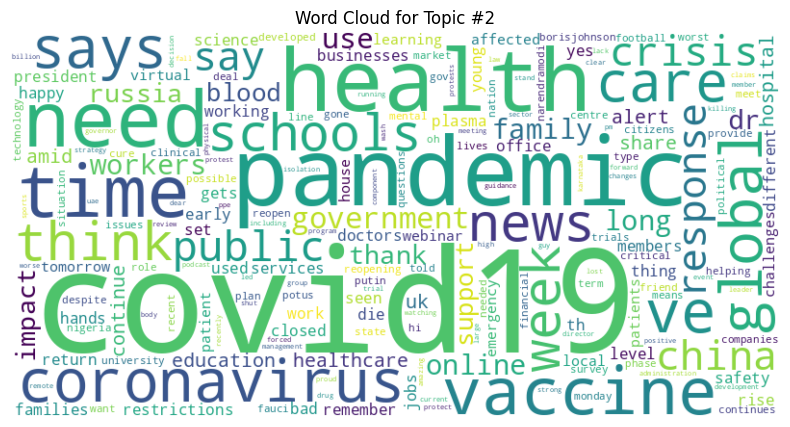

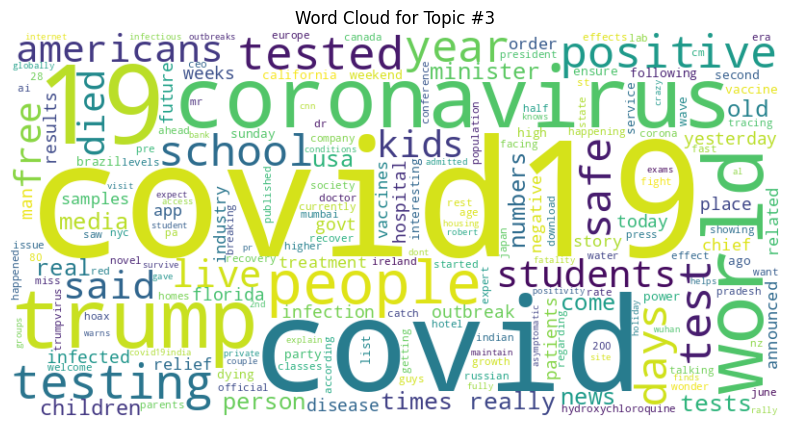

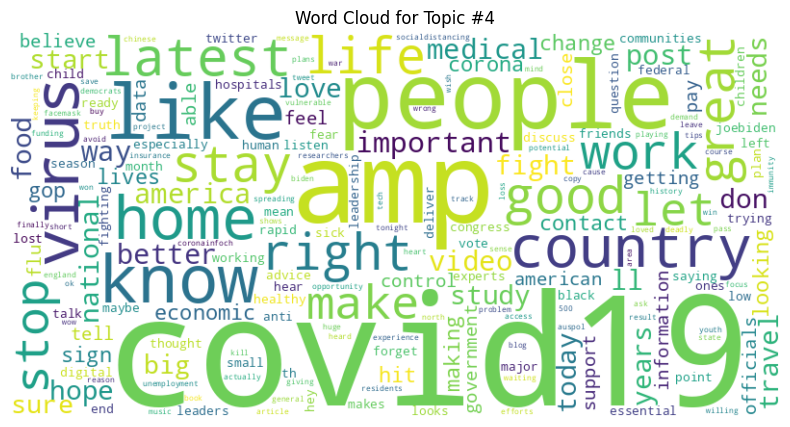

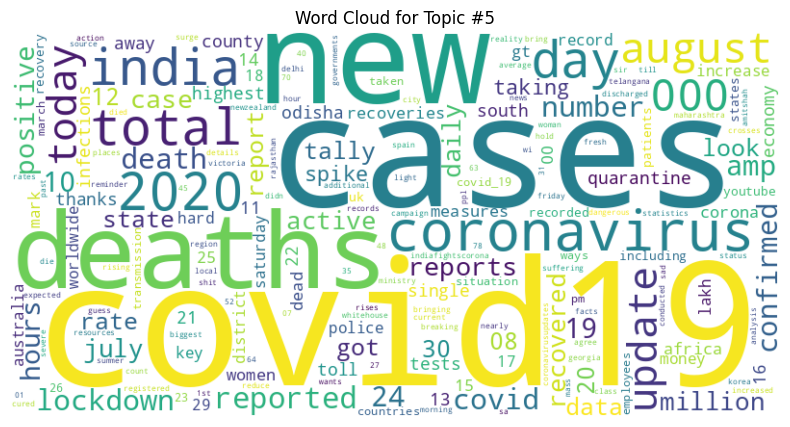

In [6]:
# Visualização de nuvens de palavras por tópico
def plot_wordclouds(lda_model, vectorizer):
    for topic_idx, topic in enumerate(lda_model.components_):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
            dict(zip(vectorizer.get_feature_names_out(), topic))
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Topic #{topic_idx + 1}')
        plt.show()

plot_wordclouds(lda_model, vectorizer)

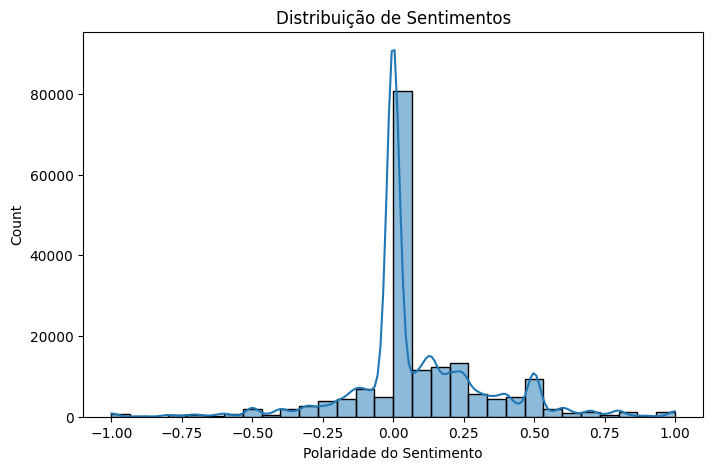

In [7]:
# Visualização de dados
plt.figure(figsize=(8, 5))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Distribuição de Sentimentos')
plt.xlabel('Polaridade do Sentimento')
plt.show()

In [ ]:
# Treinamento de um classificador de Naive Bayes para análise de sentimentos
X = df['text']
y = df['sentiment'].apply(lambda x: 'positivo' if x > 0 else ('negativo' if x < 0 else 'neutro'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)

In [9]:
# Avaliação do classificador
y_pred = classifier.predict(X_test_vec)
print("\nAvaliação do Classificador:")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Avaliação do Classificador:
Acurácia: 0.7744402880911172

Matriz de Confusão:
[[ 1626   975  3351]
 [   84 11965  2988]
 [   94   588 14151]]

Relatório de Classificação:
              precision    recall  f1-score   support

    negativo       0.90      0.27      0.42      5952
      neutro       0.88      0.80      0.84     15037
    positivo       0.69      0.95      0.80     14833

    accuracy                           0.77     35822
   macro avg       0.83      0.67      0.69     35822
weighted avg       0.81      0.77      0.75     35822

